In [ ]:
import os
import numpy as np
import scipy.signal as sp_sig
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
import graph_surrogate as gs
import graph_transform as gt
import graph_inference as gi
import modularity

# Preliminaries and Data Loading

In [ ]:
# Modify path to MAT-file containing seizure data
path_base = './rawdata'

path_seizure = os.path.join(path_base, 'ieeg_seizure.mat')
path_nodelbl = os.path.join(path_base, 'ieeg_nodes.csv')
path_sozlbl = os.path.join(path_base, 'soz_nodes.csv')

# Load iEEG seizure signal data
data = h5py.File(path_seizure, 'r')
signal = data['evData'][...]
n_sample, n_channel = signal.shape
fs = data['Fs'][0,0]

# Construct a timestamp vector
time_vector = np.arange(n_sample) / fs

# Common Average Re-reference
signal = (signal.T - signal.mean(axis=1)).T

# Load node label data
node_lbl = np.loadtxt(path_nodelbl, delimiter=',', dtype=str)
soz_lbl = np.loadtxt(path_sozlbl, delimiter=',', dtype=str)
soz_idx = np.array([np.flatnonzero(node_lbl == lbl)[0]
                    for lbl in soz_lbl if lbl in node_lbl])
nsoz_idx = np.setdiff1d(np.arange(n_channel), soz_idx)

# Plot the Montage

In [ ]:
# Channel-wise Z-Score of the signal to remove mean and scale to unit amplitude
signal_zs = (signal - signal.mean(axis=0)) / signal.std(axis=0)

# Adjust the scaling 
y_scaling = 6
channel_y_offset = y_scaling*np.arange(n_channel)

plt.figure(figsize=(6, 4), dpi=300)
ax = plt.subplot(111)
ax.plot(time_vector, signal_zs[:, nsoz_idx] + channel_y_offset[nsoz_idx],
        linewidth=0.5, color='k');
ax.plot(time_vector, signal_zs[:, soz_idx] + channel_y_offset[soz_idx],
        linewidth=0.5, color='r');
ax.set_xlim([time_vector[0], time_vector[-1]])
ax.set_yticks(channel_y_offset[::3],
              (np.arange(n_channel)+1)[::3])
ax.set_ylabel('ECoG Channels\n(graph nodes)')
ax.set_xlabel('Time (sec)')
ax.set_title('Seizure Recorded using Electrocorticography (ECoG)')
ax.set_ylim([-y_scaling, n_channel*y_scaling])
plt.show()

# Static Graph Inference using Cross-Correlation Analysis

In [ ]:
# Grab the first 5s of the seizure to reflect onset
onset_clip_idx = int(fs*10)
signal = signal[:onset_clip_idx]
time_vector = time_vector[:onset_clip_idx]

## Compute full cross-correlation matrix

In [ ]:
# Estimate the lagged cross-correlation between all nodal time-series
xcr_matr, lags = gi.xcorr_full(signal, fs=fs)

# Unwrap the lagged cross-correlation matrix (lags x nodes x nodes) into a vectorized representation (lags x edges)
xcr_matr_cfg = np.abs(gt.adj_to_cfg(xcr_matr)[0])

### Visualize the distribution of cross-correlation values over time lags across all graph edge

In [ ]:
# Identify time-lag of peak cross-correlation magnitude per graph edge
# Sort the graph edges based on the latency of the cross-correlation
edge_reord = np.argsort(np.argmax(xcr_matr_cfg, axis=0))

# Heatmap of the cross-correlation matrix
plt.figure(figsize=(9, 6), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(xcr_matr_cfg[:, edge_reord].T,
                interpolation='none',
                extent=[lags[0], lags[-1], 0, xcr_matr_cfg.shape[-1]],
                aspect=(lags[-1]-lags[0])/xcr_matr_cfg.shape[-1],
                vmin=0, vmax=1)
plt.colorbar(mat, ax=ax, label='Magnitude Cross-Correlation', shrink=0.6)
ax.set_xlabel('Time Delay (sec)')
ax.set_ylabel('Graph Edges (sorted by delay)')
plt.show()

## Use cross-correlation matrix to construct functional graphs

In [ ]:
# Construct a graph based on edges that reflect fast propagation (10-1000 ms)
adj_fast = gi.xcorr_full_to_adj(xcr_matr, lags, tau_cut=(0.01, 1.0))

# Construct a graph based on edges that reflect slow propagation (1000 - 2000 ms)
adj_slow = gi.xcorr_full_to_adj(xcr_matr, lags, tau_cut=(1.0, 2.0))

In [ ]:
plt.figure(figsize=(3,3), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(adj_fast, cmap='Blues', vmin=0, vmax=0.5);
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes')
ax.set_ylabel('graph nodes')
ax.set_title('Fast Timescale Interaction (10-1000 ms)')
plt.show()

plt.figure(figsize=(3,3), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(adj_slow, cmap='Blues', vmin=0, vmax=0.5);
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes')
ax.set_ylabel('graph nodes')
ax.set_title('Slow Timescale Interaction (1000-2000 ms)')
plt.show()

# Preservation of Edge Strength

## Manual titration of critical threshold

In [ ]:
alpha = np.linspace(0, 1, 1000)
slow_edge_density = [np.mean(adj_slow > a) for a in alpha]
fast_edge_density = [np.mean(adj_fast > a) for a in alpha]

plt.figure(figsize=(4,3), dpi=300)
ax= plt.subplot(111)
ax.scatter(alpha, slow_edge_density, marker='.', color='b', s=3, label='Slow Connectivity')
ax.scatter(alpha, fast_edge_density, marker='.', color='r', s=3, label='Fast Connectivity')
plt.legend()
ax.set_xlabel(r'Critical Threshold ($\alpha$)')
ax.set_ylabel(r'Graph Edge Density')

## Automated discovery of robust edges

In [ ]:
signal_unif_shuf = gs.uniform_shuffle(signal, fixed_order=False)
signal_phase_shuf = gs.fourier_constrained_shuffle(signal, fixed_phase=False)

node_ix = soz_idx[1]

adj_orig = gi.xcorr_full_to_adj(*gi.xcorr_full(signal, fs=fs), tau_cut=(0.01, 1.0))
adj_unif_shuf = gi.xcorr_full_to_adj(*gi.xcorr_full(signal_unif_shuf, fs=fs), tau_cut=(0.01, 1.0))
adj_phase_shuf = gi.xcorr_full_to_adj(*gi.xcorr_full(signal_phase_shuf, fs=fs), tau_cut=(0.01, 1.0))


fig = plt.figure(figsize=(16,9), dpi=300)

#####
# Original data
#####
ax = plt.subplot(3,4,1)
sns.despine(fig, ax)
ax.plot(time_vector, signal[:, node_ix], linewidth=0.5, color='k')
ax.set_ylabel('ECoG Amplitude (a.u.)')
ax.set_xlabel('Time (sec)')
ax.set_title('Original Node Time-Series (during seizure)')

ax = plt.subplot(3,4,2)
sns.despine(fig, ax)
ax.hist(signal[:, node_ix], bins=50, density=True, color='k')
ax.set_ylabel('Proportion')
ax.set_xlabel('ECoG Amplitude (a.u.)')

ax = plt.subplot(3,4,3)
sns.despine(fig, ax)
ax.psd(signal[:, node_ix], noverlap=1023, NFFT=1024, Fs=fs, linewidth=0.5, color='k')

ax = plt.subplot(3,4,4)
mat = ax.imshow(adj_orig, cmap='Blues', vmin=0, vmax=0.5);
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes')
ax.set_ylabel('graph nodes')

#####
# Uniform-Shuffled Surrogate
#####
ax = plt.subplot(3,4,5)
sns.despine(fig, ax)
ax.plot(time_vector, signal_unif_shuf[:, node_ix], linewidth=0.5, color='k')
ax.set_ylabel('ECoG Amplitude (a.u.)')
ax.set_xlabel('Time (sec)')
ax.set_title('Uniform Random Shuffle')

ax = plt.subplot(3,4,6)
sns.despine(fig, ax)
ax.hist(signal_unif_shuf[:, node_ix], bins=50, density=True, color='k')
ax.set_ylabel('Proportion')
ax.set_xlabel('ECoG Amplitude (a.u.)')

ax = plt.subplot(3,4,7)
sns.despine(fig, ax)
ax.psd(signal_unif_shuf[:, node_ix], noverlap=1023, NFFT=1024, Fs=fs, linewidth=0.5, color='k')

ax = plt.subplot(3,4,8)
mat = ax.imshow(adj_unif_shuf, cmap='Blues', vmin=0, vmax=0.5);
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes')
ax.set_ylabel('graph nodes')

#####
# Phase-Shuffled Surrogate
#####
ax = plt.subplot(3,4,9)
sns.despine(fig, ax)
ax.plot(time_vector, signal_phase_shuf[:, node_ix], linewidth=0.5, color='k')
ax.set_ylabel('ECoG Amplitude (a.u.)')
ax.set_xlabel('Time (sec)')
ax.set_title('Fourier-constrained Phase Shuffle')

ax = plt.subplot(3,4,10)
sns.despine(fig, ax)
ax.hist(signal_phase_shuf[:, node_ix], bins=50, density=True, color='k')
ax.set_ylabel('Proportion')
ax.set_xlabel('ECoG Amplitude (a.u.)')

ax = plt.subplot(3,4,11)
sns.despine(fig, ax)
ax.psd(signal_phase_shuf[:, node_ix], noverlap=1023, NFFT=1024, Fs=fs, linewidth=0.5, color='k')

ax = plt.subplot(3,4,12)
mat = ax.imshow(adj_phase_shuf, cmap='Blues', vmin=0, vmax=0.5);
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes')
ax.set_ylabel('graph nodes')

plt.tight_layout()
plt.show()

# Graph Topology

## Local Topology of SOZ and Non-SOZ Nodes 

In [ ]:
# Weighted degree centrality for each graph node
wgt_deg = adj_orig.sum(axis=0) / (n_channel - 1)

plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
ax.bar(x=nsoz_idx, height=wgt_deg[nsoz_idx], color='k')
ax.bar(x=soz_idx, height=wgt_deg[soz_idx], color='r')
ax.set_ylabel('Weighted Degree Centrality')
ax.set_xlabel('Graph Nodes')
plt.legend(['Nodes outside SOZ',
            'Nodes within SOZ'])
ax.set_ylim([0, 0.4])
ax.set_xlim([0, n_channel])
plt.show()

## Preferential graph connectivity

### Nodes within SOZ

In [ ]:
# Total connectivity amongst SOZ nodes
wgt_soz_conn = adj_orig[soz_idx, :][:, soz_idx].sum()

# Compare to connectivity amongst nodes drawn randomly from the network
wgt_soz_conn_null = []
for i in range(1000):
    null_soz_idx = np.random.permutation(n_channel)[:len(soz_idx)]
    wgt_soz_conn_null.append(adj_orig[null_soz_idx, :][:, null_soz_idx].sum())
    
# Compare true total connectivity within SOZ to random draws
pval = np.mean(np.array(wgt_soz_conn_null) > wgt_soz_conn)
        
plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
ax.hist(wgt_soz_conn_null, bins=50, density=True, color='k', label='Randomly drawn nodes')
ax.axvline(wgt_soz_conn, color='r', label='Nodes in SOZ')
ax.set_ylabel('Proportion')
ax.set_xlabel('Total Edge Strength within Node Group')
ax.set_ylim([0, 1.0])
ax.text(10, 0.5, 'p={:0.3f}'.format(pval), color='r')
plt.legend()
plt.show()

### Nodes outside SOZ

In [ ]:
# Total connectivity outside SOZ nodes
wgt_nsoz_conn = adj_orig[nsoz_idx, :][:, nsoz_idx].sum()

# Compare to connectivity amongst nodes drawn randomly from the network
wgt_nsoz_conn_null = []
for i in range(1000):
    null_nsoz_idx = np.random.permutation(n_channel)[:len(nsoz_idx)]
    wgt_nsoz_conn_null.append(adj_orig[null_nsoz_idx, :][:, null_nsoz_idx].sum())
    
# Compare true total connectivity within SOZ to random draws    
pval = np.mean(np.array(wgt_nsoz_conn_null) > wgt_nsoz_conn)
        
plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
ax.hist(wgt_nsoz_conn_null, bins=50, density=True, color='k', label='Randomly drawn nodes')
ax.axvline(wgt_nsoz_conn, color='r', label='Nodes outside SOZ')
ax.set_ylabel('Proportion')
ax.set_xlabel('Total Edge Strength within Node Group')
ax.set_ylim([0, 0.1])
ax.text(600, 0.06, 'p={:0.3f}'.format(pval), color='r')
plt.legend()
plt.show()

## Measuring modular structure in the graph

### Identify modules for a fixed gamma


Merging 58 communities 

   --- Found   16 communities in 0.04890 sec 
   --- Found   10 communities in 0.06781 sec 
   --- Found    7 communities in 0.08458 sec 
   --- Found    7 communities in 0.09898 sec 
   --- Found    7 communities in 0.11344 sec 

Merging 7 communities 

   --- Found    4 communities in 0.00236 sec 
   --- Found    4 communities in 0.00421 sec 

Merging 4 communities 

   --- Found    4 communities in 0.00114 sec 




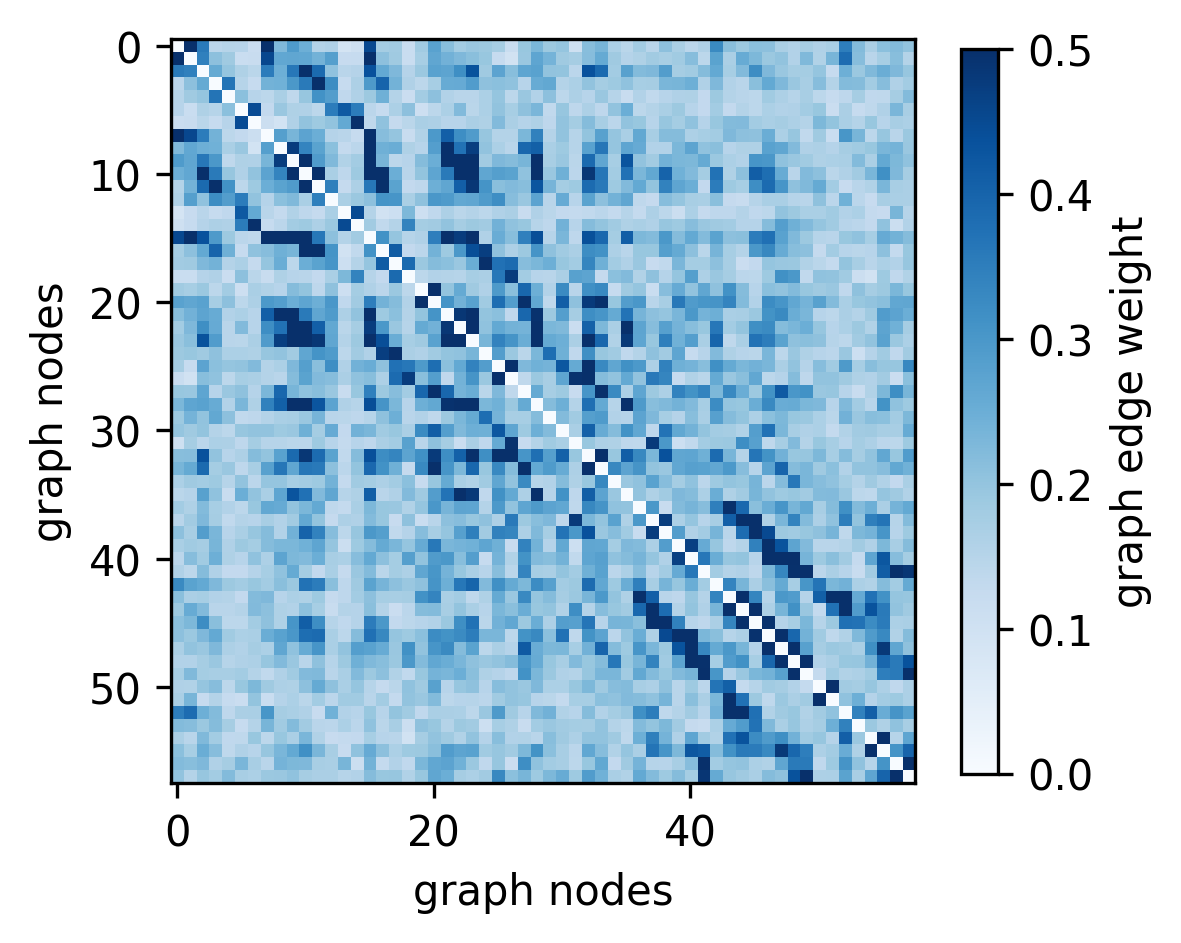

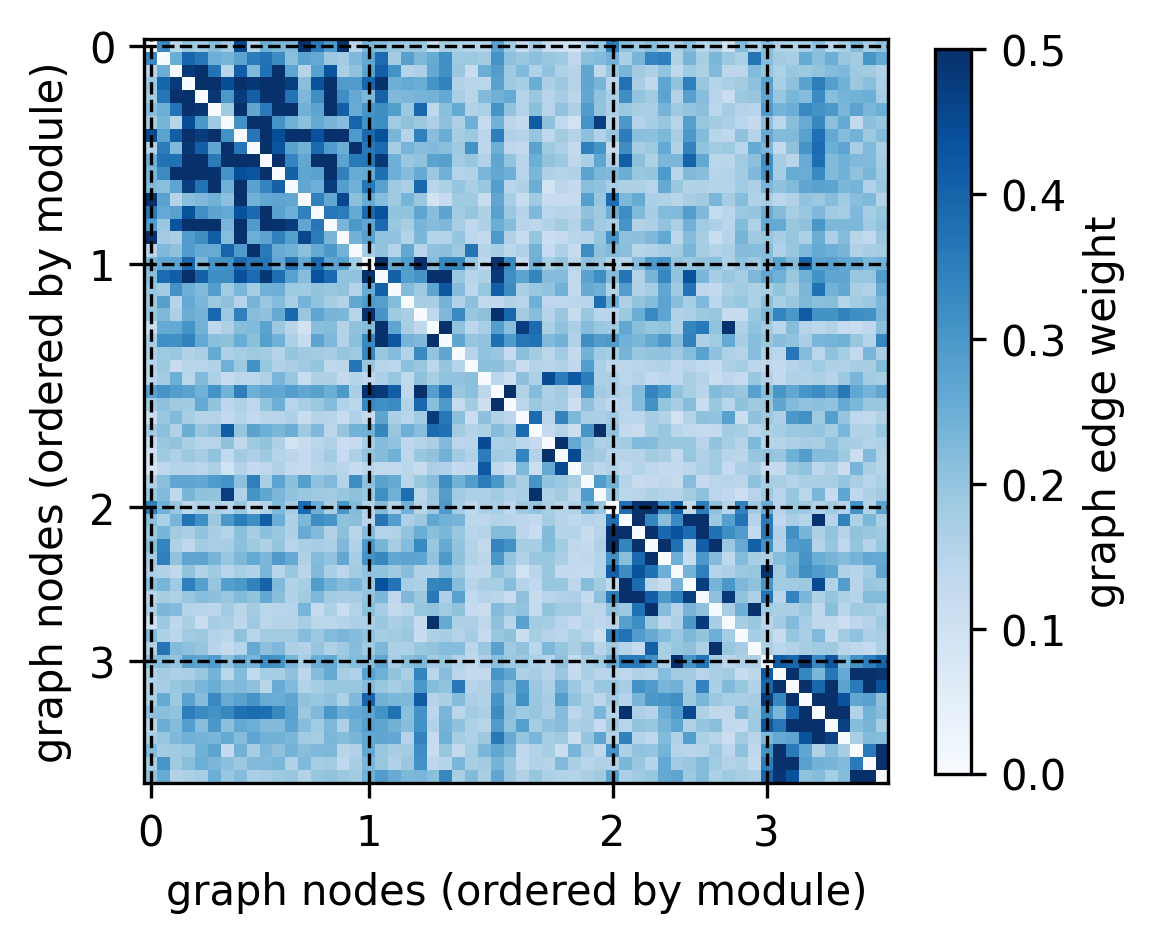

In [138]:
gamma = 2.0
B = modularity.matrix.super_modularity_matr(
    ml_adj_matr=np.expand_dims(adj_orig, axis=0),
    layer_weight_matr=np.zeros((1,1)),
    null_ml_adj_matr=gamma*np.expand_dims(orig_ng_null, axis=0))
modules, _ = modularity.genlouvain(B, limit=2000, verbose=True)

mod_id, mod_ix = np.unique(np.sort(modules), return_index=True)

plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(adj_orig, cmap='Blues', vmin=0, vmax=0.5);
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes')
ax.set_ylabel('graph nodes')
plt.show()

plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(adj_orig[np.argsort(modules), :][:, np.argsort(modules)],
                cmap='Blues', vmin=0, vmax=0.5);
ax.set_yticks(mod_ix, mod_id)
ax.set_xticks(mod_ix, mod_id)
ax.grid(True, color='k', linestyle='--')
plt.colorbar(mat, ax=ax, shrink=0.8, label='graph edge weight');
ax.set_xlabel('graph nodes (ordered by module)')
ax.set_ylabel('graph nodes (ordered by module)')
plt.show()

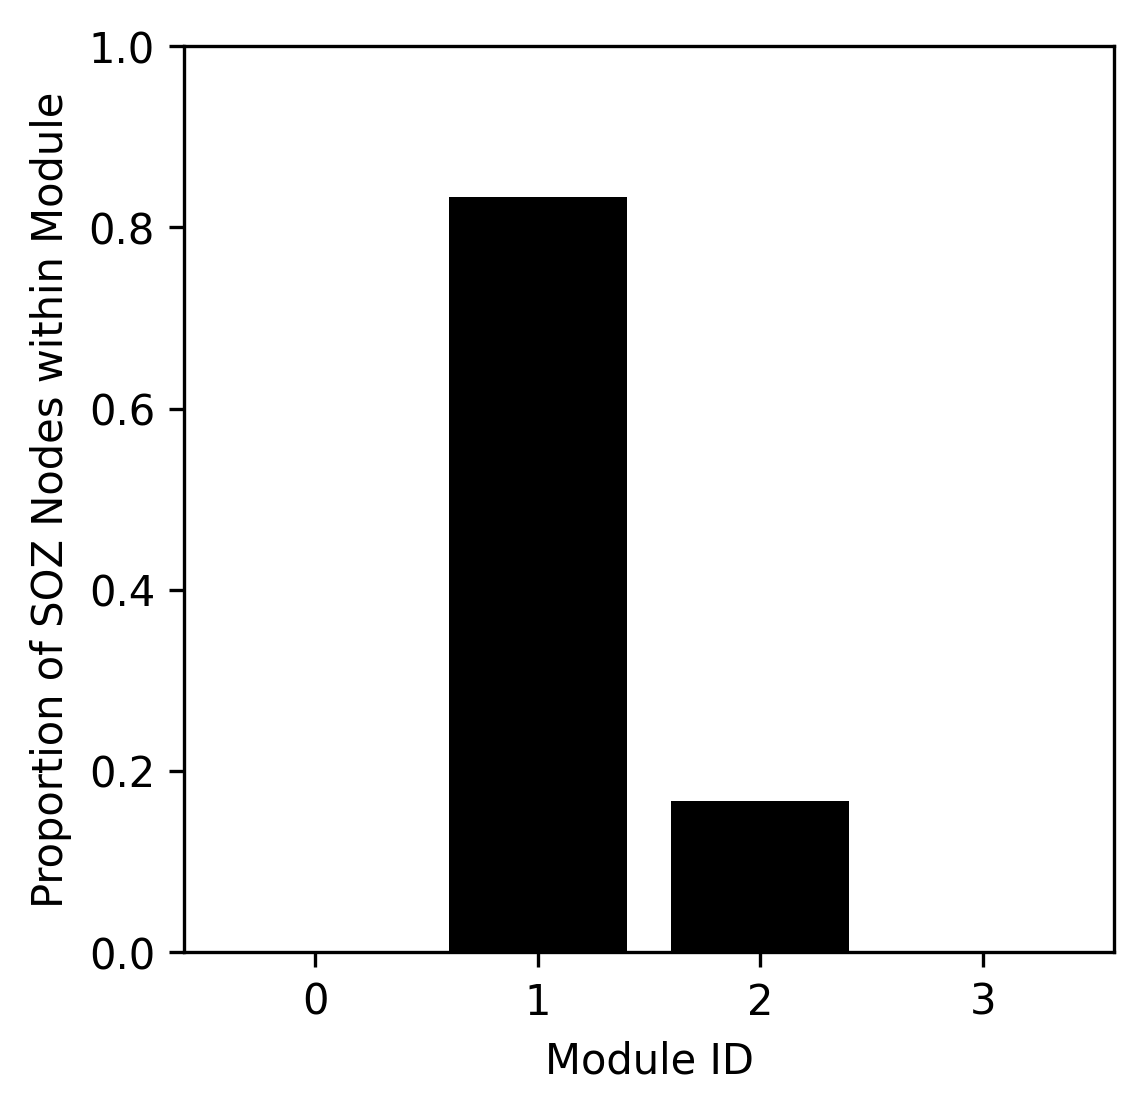

In [146]:
# Overlap between graph modules and SOZ nodes
overlap = [sum(modules[soz_idx] == mid) / len(soz_idx) for mid in mod_id]

plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
ax.bar(x=mod_id, height=overlap, color='k')
ax.set_ylabel('Proportion of SOZ Nodes within Module')
ax.set_xlabel('Module ID')
ax.set_ylim([0, 1])
plt.show()